In [1]:
import os
os.chdir('../')

import warnings
warnings.filterwarnings('ignore')

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os

!nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"]="3"

Sat Jan 20 04:45:57 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.223.02   Driver Version: 470.223.02   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100 80G...  Off  | 00000000:1B:00.0 Off |                    0 |
| N/A   29C    P0    42W / 300W |     35MiB / 80994MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA A100 80G...  Off  | 00000000:1C:00.0 Off |                    0 |
| N/A   

### Model Parts

In [3]:
from model.main.enc_prior_latent_quantizer_dec import Model
from model.encoder.net_64_encoder import Encoder
from model.prior.randn_prior import Prior
from model.latent.dalle_lse_latent import Latent
from model.quantizer.dalle_nearest_quantizer import Quantizer
from model.decoder.net_64_decoder import Decoder

from tensorboardX import SummaryWriter
from util.util import *

### Model Init.

In [4]:
from easydict import EasyDict
hp = EasyDict()
hp.img_size = 64
hp.n_resblocks = 6
hp.z_dim = 512
hp.n_prior_embeddings = 512
hp.init_log_sigma = -8
hp.const_sigma = True
hp.quantize = True

In [5]:
step = 0
device = 'cuda:0'

model_list = []
optimizer_list = []
for i in range(1):
    model = Model(Encoder(**hp), Prior(**hp), Latent(**hp), Quantizer(**hp), Decoder(**hp))
    model = model.to(device)
    model_list.append(model)
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
    optimizer_list.append(optimizer)

for name, module in model.named_modules():
    if len(name.split('.')) <= 2 and len(name) > 0:
        print(name, get_size(module))

print('done')

encoder 77.1279296875
encoder.encoder 77.1279296875
prior 1.0
latent 3.814697265625e-06
quantizer 0.0
decoder 67.1142692565918
decoder.decoder 67.1142692565918
done


### Load

In [6]:
save_dir = '/data/scpark/save/lse/train_dalle/train01.19-8/'

!mkdir -p $save_dir
!ls -lt $save_dir

writer = SummaryWriter(save_dir)

if False:
    step, model_list, optimizer_list = load_model_list(save_dir, 2195, model_list, optimizer_list)

total 890336
-rw-rw-r-- 1 scpark scpark   1583209  1월 20 04:45 events.out.tfevents.1705693121.GPUSVR11
-rw-rw-r-- 1 scpark scpark 455057031  1월 20 04:45 save_10000
-rw-rw-r-- 1 scpark scpark 455049855  1월 20 04:38 save_0
-rw-rw-r-- 1 scpark scpark      2649  1월 20 04:38 events.out.tfevents.1705693091.GPUSVR11


### Dataset

In [7]:
from torch.utils.data import DataLoader, Dataset
from data.imagenet_dataset import ImagenetDataset

train_data_dir = '/data/imagenet/val'
train_dataset = ImagenetDataset(root_dir=train_data_dir, img_size=hp.img_size)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=8)
print('done')

done


In [8]:
def preprocess(batch):
    x, t = batch
    data = {}
    data['x'] = x.to(device)
    data['t'] = t.to(device)
    return data

### Train

In [9]:
def plot(x):
    _x = x.permute(0, 2, 3, 1).data.cpu().numpy()
    plt.figure(figsize=[18, 4])
    for i in range(8):
        plt.subplot(1, 8, i+1)
        plt.imshow(_x[i])
        plt.xticks([])
        plt.yticks([])
    plt.show()

In [10]:
def linear(start_value, end_value, current_index, start_index, end_index):
    if current_index > end_index:
        return end_value
    if current_index < start_index:
        return start_value

    grad = (end_value - start_value) / (end_index - start_index)
    y = start_value + grad * (current_index - start_index)

    return y

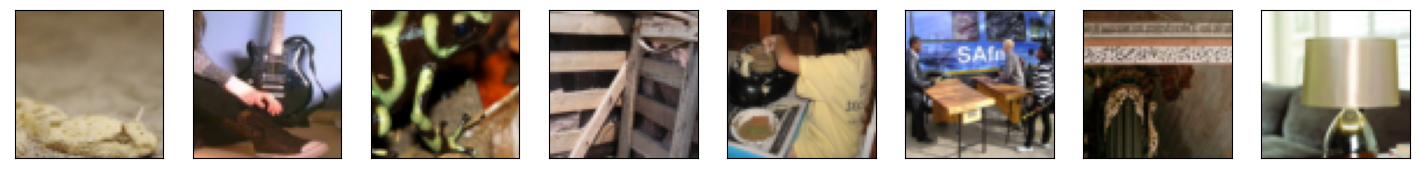

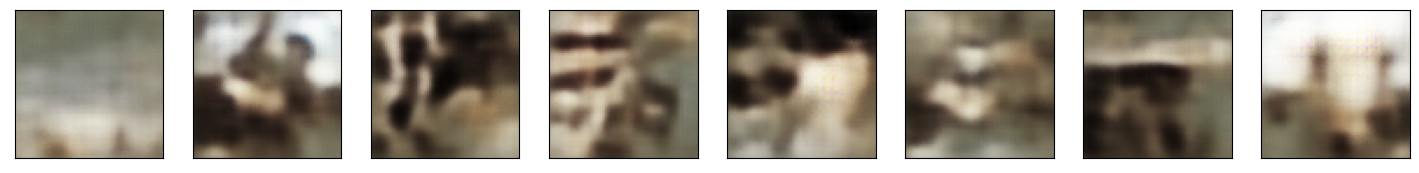

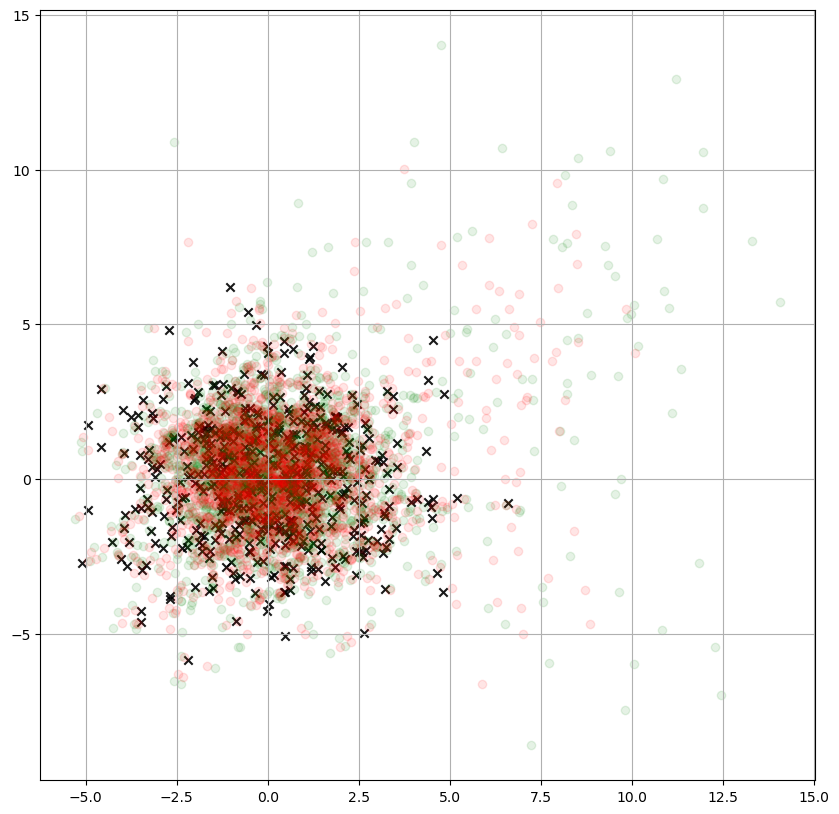

3001
lse_loss 460845696.0
commit_loss 3.131051540374756
recon_loss 0.014634276740252972
3002
lse_loss 469316096.0
commit_loss 3.2004590034484863
recon_loss 0.01980733685195446
3003
lse_loss 474347328.0
commit_loss 3.389016628265381
recon_loss 0.019128669053316116
3004
lse_loss 451973248.0
commit_loss 3.3113579750061035
recon_loss 0.02399080991744995
3005
lse_loss 425484352.0
commit_loss 3.425602912902832
recon_loss 0.023345734924077988
3006
lse_loss 497937152.0
commit_loss 3.432020902633667
recon_loss 0.01607835292816162
3007
lse_loss 489344256.0
commit_loss 3.220618486404419
recon_loss 0.015998711809515953
3008
lse_loss 467010784.0
commit_loss 3.2156081199645996
recon_loss 0.02108520083129406
3009
lse_loss 499463008.0
commit_loss 3.292231559753418
recon_loss 0.014758769422769547
3010
lse_loss 461222976.0
commit_loss 3.2117433547973633
recon_loss 0.02271486446261406
3011
lse_loss 504266464.0
commit_loss 3.3087308406829834
recon_loss 0.013890571892261505
3012
lse_loss 470708416.0
commit

lse_loss 455481472.0
commit_loss 3.330768585205078
recon_loss 0.02329988405108452
3096
lse_loss 488700736.0
commit_loss 3.353510856628418
recon_loss 0.015008355490863323
3097
lse_loss 470313248.0
commit_loss 3.505472183227539
recon_loss 0.02073449268937111
3098
lse_loss 509099008.0
commit_loss 3.3658809661865234
recon_loss 0.016833296045660973
3099
lse_loss 487516544.0
commit_loss 3.5878586769104004
recon_loss 0.014411434531211853
3100
lse_loss 449478880.0
commit_loss 3.5177199840545654
recon_loss 0.014524046331644058
3101
lse_loss 409075232.0
commit_loss 3.2895750999450684
recon_loss 0.01720285415649414
3102
lse_loss 489999168.0
commit_loss 3.2362444400787354
recon_loss 0.014333337545394897
3103
lse_loss 588908032.0
commit_loss 3.366781234741211
recon_loss 0.014630968682467937
3104
lse_loss 431493312.0
commit_loss 3.4259016513824463
recon_loss 0.024724682793021202
3105
lse_loss 473047296.0
commit_loss 3.3466007709503174
recon_loss 0.016172591596841812
3106
lse_loss 447299264.0
commit_

lse_loss 493222656.0
commit_loss 3.372382402420044
recon_loss 0.01945551671087742
3191
lse_loss 583080832.0
commit_loss 3.6244518756866455
recon_loss 0.014797218143939972
3192
lse_loss 484958880.0
commit_loss 3.4344584941864014
recon_loss 0.017129044979810715
3193
lse_loss 476433088.0
commit_loss 3.486046075820923
recon_loss 0.018251679837703705
3194
lse_loss 479226304.0
commit_loss 3.4645204544067383
recon_loss 0.014869630336761475
3195
lse_loss 438787456.0
commit_loss 3.4877421855926514
recon_loss 0.022377243265509605
3196
lse_loss 518360000.0
commit_loss 3.4474031925201416
recon_loss 0.025921745225787163
3197
lse_loss 523264448.0
commit_loss 3.352993965148926
recon_loss 0.022550560534000397
3198
lse_loss 525465728.0
commit_loss 3.531646966934204
recon_loss 0.012520438060164452
3199
lse_loss 478004928.0
commit_loss 3.3950376510620117
recon_loss 0.023870456963777542
3200
lse_loss 535132352.0
commit_loss 3.3415021896362305
recon_loss 0.015325507149100304
3201
lse_loss 470471712.0
commi

lse_loss 391211936.0
commit_loss 3.451124668121338
recon_loss 0.020462259650230408
3287
lse_loss 457320576.0
commit_loss 3.534944534301758
recon_loss 0.024188494309782982
3288
lse_loss 494453440.0
commit_loss 3.4702577590942383
recon_loss 0.01340133510529995
3289
lse_loss 479258624.0
commit_loss 3.263218879699707
recon_loss 0.0217817984521389
3290
lse_loss 409053760.0
commit_loss 3.338968276977539
recon_loss 0.0201523806899786
3291
lse_loss 427122656.0
commit_loss 3.323178768157959
recon_loss 0.0200644563883543
3292
lse_loss 415768480.0
commit_loss 3.6100432872772217
recon_loss 0.021705379709601402
3293
lse_loss 463991040.0
commit_loss 3.52498459815979
recon_loss 0.02122863195836544
3294
lse_loss 488365184.0
commit_loss 3.489943265914917
recon_loss 0.01721975952386856
3295
lse_loss 428866240.0
commit_loss 3.5200772285461426
recon_loss 0.02142399549484253
3296
lse_loss 409858432.0
commit_loss 3.3937270641326904
recon_loss 0.016210470348596573
3297
lse_loss 453676736.0
commit_loss 3.5190

lse_loss 430656352.0
commit_loss 3.5777323246002197
recon_loss 0.018870700150728226
3383
lse_loss 408453344.0
commit_loss 3.268874168395996
recon_loss 0.03226282447576523
3384
lse_loss 408881440.0
commit_loss 3.498776435852051
recon_loss 0.024170853197574615
3385
lse_loss 452287072.0
commit_loss 3.479663133621216
recon_loss 0.017132222652435303
3386
lse_loss 409783808.0
commit_loss 3.3895695209503174
recon_loss 0.015600761398673058
3387
lse_loss 458399584.0
commit_loss 3.4553301334381104
recon_loss 0.02317064255475998
3388
lse_loss 399871488.0
commit_loss 3.7303853034973145
recon_loss 0.019043413922190666
3389
lse_loss 400203264.0
commit_loss 3.5834054946899414
recon_loss 0.021611636504530907
3390
lse_loss 413927776.0
commit_loss 3.586737632751465
recon_loss 0.018800940364599228
3391
lse_loss 454965280.0
commit_loss 3.6091060638427734
recon_loss 0.015817057341337204
3392
lse_loss 432492288.0
commit_loss 3.367201328277588
recon_loss 0.01941980980336666
3393
lse_loss 492534272.0
commit_l

lse_loss 509568768.0
commit_loss 3.390979290008545
recon_loss 0.019170861691236496
3479
lse_loss 419457952.0
commit_loss 3.5291013717651367
recon_loss 0.013624927960336208
3480
lse_loss 477905056.0
commit_loss 3.4639062881469727
recon_loss 0.013826705515384674
3481
lse_loss 366885184.0
commit_loss 3.5048489570617676
recon_loss 0.023697294294834137
3482
lse_loss 435610752.0
commit_loss 3.5359926223754883
recon_loss 0.025266578420996666
3483
lse_loss 438768672.0
commit_loss 3.445587158203125
recon_loss 0.013047521933913231
3484
lse_loss 521604160.0
commit_loss 3.6694188117980957
recon_loss 0.024243241176009178
3485
lse_loss 410382880.0
commit_loss 3.5213489532470703
recon_loss 0.016883309930562973
3486
lse_loss 476432000.0
commit_loss 3.4129350185394287
recon_loss 0.020762290805578232
3487
lse_loss 449919904.0
commit_loss 3.53139591217041
recon_loss 0.03506167232990265
3488
lse_loss 432785408.0
commit_loss 3.297720432281494
recon_loss 0.016713425517082214
3489
lse_loss 462754368.0
commit

lse_loss 348256448.0
commit_loss 3.548402786254883
recon_loss 0.017801713198423386
3575
lse_loss 411603328.0
commit_loss 3.4121646881103516
recon_loss 0.013916994445025921
3576
lse_loss 534927680.0
commit_loss 3.5184507369995117
recon_loss 0.01953163370490074



KeyboardInterrupt



In [11]:
from IPython import display

min_indices = set()
while True:
    for batch in train_loader:
        print(step)
        
        loss_dict = {}
        for model, optimizer in zip(model_list, optimizer_list):
            data = preprocess(batch)

            # Forward
            model.train()
            model.zero_grad()
            quant_temp = linear(1, 0, step, 0, 10*1000)
            data = model(data, quant_temp=quant_temp, latent_temp=1)
            min_indices.update(list(data['min_indices'].data.cpu().numpy()))

            # Backward
            loss = 0
            for key in data.keys():
                if 'lse_loss' in key:
                    loss = loss + data[key] * linear(1, 0, step, 0, 10*1000)
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                elif 'commit_loss' in key:
                    loss = loss + data[key] * linear(0, 1, step, 0, 10*1000)
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]        
                elif 'loss' in key:
                    loss = loss + data[key]
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                    
            loss.backward()
            optimizer.step()
            
#             alpha = 1e-3
#             model.prior.prior.data = (1-alpha)*model.prior.prior.data + alpha*data['e_new'].data
        
        for key in loss_dict:
            writer.add_scalar(key, np.mean(loss_dict[key]), step)
            print(key, np.mean(loss_dict[key]))
        
        if step % 1000 == 0:
            import matplotlib.pyplot as plt
            display.clear_output()
            
            x = data['x']
            y = data['y']
            
            plot(x)
            plot(y)
            
            from sklearn.decomposition import PCA
            pca = PCA(n_components=2)
            e = model.prior.prior.data.cpu().numpy()
            pca.fit(e)
            e_pca = pca.transform(e)
            ze_pca = pca.transform(data['ze'].permute(0, 2, 3, 1).reshape(-1, hp.z_dim).data.cpu().numpy())
            zq_pca = pca.transform(data['zq'].permute(0, 2, 3, 1).reshape(-1, hp.z_dim).data.cpu().numpy())
            plt.figure(figsize=[10, 10])
            plt.scatter(e_pca[:, 0], e_pca[:, 1], marker='x', alpha=0.9, color='black')
            plt.scatter(ze_pca[:, 0], ze_pca[:, 1], marker='o', alpha=0.1, color='green')
            plt.scatter(zq_pca[:, 0], zq_pca[:, 1], marker='o', alpha=0.1, color='red')
            plt.grid()
            plt.show() 
            
            usage = len(min_indices) / hp.n_prior_embeddings
            writer.add_scalar('usage', usage, step)
            min_indices = set()
    
        if step % 10000 == 0:
            save_model_list(save_dir, step, model_list, optimizer_list)
                
        step += 1
        

In [ ]:
save_model_list(save_dir, step, model_list, optimizer_list)
print('done')